In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447542,10588.793237,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214032,25047.188462,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212376,50797.690402,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130084,74999.343414,360.000000,7.799086,16.421115,7.252319


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#counting
weather_counts = df['SYNOPCode'].value_counts()
print(weather_counts)

0    56964
6    25018
5     6605
8     1716
4      466
7      419
3      191
Name: SYNOPCode, dtype: int64


In [5]:
#stratified sampling trainset
X_synop_0 = X_train[X_train['SYNOPCode'] == 0]
y_synop_0_FSO = y_FSO_train[X_synop_0.index]
y_synop_0_RFL = y_RFL_train[X_synop_0.index]
# group trainset by Distance, time and Frequency
# create an empty list to save sample
sampled_X = []
sampled_y_FSO = []
sampled_y_RFL = []
#stratified sampling X
sampled_X=X_synop_0.groupby(['Distance','Frequency','Time'], group_keys=False).apply(
    lambda group:group.sample(n=min(5, len(group)), random_state=42)
)
#make Y correspond to X
sampled_y_FSO=y_synop_0_FSO.loc[sampled_X.index]
sampled_y_RFL=y_synop_0_RFL.loc[sampled_X.index]
#delete synop_0 data in the trainset
X_no_synop_0 = X_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_FSO_no_synop_0 = y_FSO_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_RFL_no_synop_0 = y_RFL_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
#merge data with deleted trainest and sampled synop_0 trainset data
X_combined = pd.concat([X_no_synop_0, sampled_X], ignore_index=True)
y_FSO_combined = pd.concat([y_FSO_no_synop_0, sampled_y_FSO], ignore_index=True)
y_RFL_combined = pd.concat([y_RFL_no_synop_0, sampled_y_RFL], ignore_index=True)
#redistribute data
combined = pd.concat([X_combined, y_FSO_combined, y_RFL_combined], axis=1)
shuffled_combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled_combined.iloc[:, :-2]
y_FSO_train = shuffled_combined.iloc[:, -2]
y_RFL_train = shuffled_combined.iloc[:, -1]

In [6]:
if (X_no_synop_0.index == y_FSO_no_synop_0.index).all():
    print("X 和 Y 索引一致")
else:
    print("X 和 Y 索引不一致")

X 和 Y 索引一致


In [7]:
if (X_train.index == y_RFL_train.index).all():
    print("X 和 Y 索引一致")
else:
    print("X 和 Y 索引不一致")

X 和 Y 索引一致


In [8]:
#data preperation
#synop_0
X_train_0 = X_train[X_train['SYNOPCode']==0].reset_index(drop=True)
X_test_0 = X_test[X_test['SYNOPCode']==0].reset_index(drop=True)
y_FSO_train_0 = y_FSO_train[X_train['SYNOPCode'] == 0].reset_index(drop=True)
y_RFL_train_0 = y_RFL_train[X_train['SYNOPCode'] == 0].reset_index(drop=True)
y_FSO_test_0 = y_FSO_test[X_test['SYNOPCode'] == 0].reset_index(drop=True)
y_RFL_test_0 = y_RFL_test[X_test['SYNOPCode'] == 0].reset_index(drop=True)
#synop_6
X_train_6 = X_train[X_train['SYNOPCode']==6].reset_index(drop=True)
X_test_6 = X_test[X_test['SYNOPCode']==6].reset_index(drop=True)
y_FSO_train_6 = y_FSO_train[X_train['SYNOPCode'] == 6].reset_index(drop=True)
y_RFL_train_6 = y_RFL_train[X_train['SYNOPCode'] == 6].reset_index(drop=True)
y_FSO_test_6 = y_FSO_test[X_test['SYNOPCode'] == 6].reset_index(drop=True)
y_RFL_test_6 = y_RFL_test[X_test['SYNOPCode'] == 6].reset_index(drop=True)
#synop_5
X_train_5 = X_train[X_train['SYNOPCode']==5].reset_index(drop=True)
X_test_5 = X_test[X_test['SYNOPCode']==5].reset_index(drop=True)
y_FSO_train_5 = y_FSO_train[X_train['SYNOPCode'] == 5].reset_index(drop=True)
y_RFL_train_5 = y_RFL_train[X_train['SYNOPCode'] == 5].reset_index(drop=True)
y_FSO_test_5 = y_FSO_test[X_test['SYNOPCode'] == 5].reset_index(drop=True)
y_RFL_test_5 = y_RFL_test[X_test['SYNOPCode'] == 5].reset_index(drop=True)
#synop_8
X_train_8 = X_train[X_train['SYNOPCode']==8].reset_index(drop=True)
X_test_8 = X_test[X_test['SYNOPCode']==8].reset_index(drop=True)
y_FSO_train_8 = y_FSO_train[X_train['SYNOPCode'] == 8].reset_index(drop=True)
y_RFL_train_8 = y_RFL_train[X_train['SYNOPCode'] == 8].reset_index(drop=True)
y_FSO_test_8 = y_FSO_test[X_test['SYNOPCode'] == 8].reset_index(drop=True)
y_RFL_test_8 = y_RFL_test[X_test['SYNOPCode'] == 8].reset_index(drop=True)
#synop_4
X_train_4 = X_train[X_train['SYNOPCode']==4].reset_index(drop=True)
X_test_4 = X_test[X_test['SYNOPCode']==4].reset_index(drop=True)
y_FSO_train_4 = y_FSO_train[X_train['SYNOPCode'] == 4].reset_index(drop=True)
y_RFL_train_4 = y_RFL_train[X_train['SYNOPCode'] == 4].reset_index(drop=True)
y_FSO_test_4 = y_FSO_test[X_test['SYNOPCode'] == 4].reset_index(drop=True)
y_RFL_test_4 = y_RFL_test[X_test['SYNOPCode'] == 4].reset_index(drop=True)
#synop_7
X_train_7 = X_train[X_train['SYNOPCode']==7].reset_index(drop=True)
X_test_7 = X_test[X_test['SYNOPCode']==7].reset_index(drop=True)
y_FSO_train_7 = y_FSO_train[X_train['SYNOPCode'] == 7].reset_index(drop=True)
y_RFL_train_7 = y_RFL_train[X_train['SYNOPCode'] == 7].reset_index(drop=True)
y_FSO_test_7 = y_FSO_test[X_test['SYNOPCode'] == 7].reset_index(drop=True)
y_RFL_test_7 = y_RFL_test[X_test['SYNOPCode'] == 7].reset_index(drop=True)
#synop_3
X_train_3 = X_train[X_train['SYNOPCode']==3].reset_index(drop=True)
X_test_3 = X_test[X_test['SYNOPCode']==3].reset_index(drop=True)
y_FSO_train_3 = y_FSO_train[X_train['SYNOPCode'] == 3].reset_index(drop=True)
y_RFL_train_3 = y_RFL_train[X_train['SYNOPCode'] == 3].reset_index(drop=True)
y_FSO_test_3 = y_FSO_test[X_test['SYNOPCode'] == 3].reset_index(drop=True)
y_RFL_test_3 = y_RFL_test[X_test['SYNOPCode'] == 3].reset_index(drop=True)

In [9]:
# #define feature selection function
def fs(trainX, trainy, testX, testy):
    # Initialize S as the set of all predictor variables
    features = trainX.columns.tolist()
    #  Initialize an empty table R
    result_table = pd.DataFrame(columns=['feature', 'RMSE', 'R2_score'])
    print('----start training----')
    while features:
        # Train a random forest with the current set of features
        rf = RandomForestRegressor(n_estimators=100, random_state=1874845, oob_score=True)
        rf.fit(trainX[features], trainy)
        
        # Calculate RMSE and R2 for the current random forest
        y_pred = rf.predict(testX[features])
        rmse = np.sqrt(mean_squared_error(testy, y_pred))
        r2 = r2_score(testy, y_pred)
        
        # Rank importance and find the least important feature
        importance = rf.feature_importances_
        importance_df = pd.DataFrame({'feature': features, 'importance': importance})
        importance_df = importance_df.sort_values(by='importance', ascending=True)
        least_important_feature = importance_df.iloc[0]['feature']
        
        # Remove the least important feature from S and log the results
        features.remove(least_important_feature)
        Feature_info = pd.DataFrame([{
            'feature': least_important_feature,
            'RMSE': rmse,
            'R2_score': r2
        }])

        # Concatenate the new row to the result table
        result_table = pd.concat([result_table, Feature_info], ignore_index=True)
        
        # Display progress
        tqdm.write(f"Removed: {least_important_feature}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return result_table



In [10]:
#define plot function
def plot_results(result_RFL, result_FSO, code):
    # Extract data from result_RFL
    features_RFL = result_RFL['feature']
    rmse_values_RFL = result_RFL['RMSE']
    r2_values_RFL = result_RFL['R2_score']

    # Extract data from result_FSO
    features_FSO = result_FSO['feature']
    rmse_values_FSO = result_FSO['RMSE']
    r2_values_FSO = result_FSO['R2_score']

    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=False)

    # Plotting result_RFL
    ax1.plot(features_RFL, rmse_values_RFL, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result_RFL
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features_RFL, r2_values_RFL, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red')
    ax1_twin.tick_params(axis='y', colors='red')
    ax1.set_title(f'SYNOP({code}) model RFL Feature Importance Analysis')

    # Plotting result_FSO
    ax2.plot(features_FSO, rmse_values_FSO, color='blue', marker='o', label='RMSE')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('RMSE', color='blue')
    ax2.tick_params(axis='x', rotation=90)
    ax2.grid(True)

    # Second y-axis for R² in result_FSO
    ax2_twin = ax2.twinx()
    ax2_twin.plot(features_FSO, r2_values_FSO, color='red', marker='x', label='R²')
    ax2_twin.set_ylabel('R²', color='red')
    ax2_twin.tick_params(axis='y', colors='red')
    ax2.set_title(f'SYNOP({code}) model FSO Feature Importance Analysis')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()


In [11]:
#define process function
def process(code):
    if code == 'Generic':
        result_RFL = fs(X_train, y_RFL_train, X_test, y_RFL_test)
        result_FSO = fs(X_train, y_FSO_train, X_test, y_FSO_test)
        return result_RFL, result_FSO
    elif code == 0:
        result_RFL = fs(X_train_0, y_RFL_train_0, X_test_0, y_RFL_test_0)
        result_FSO = fs(X_train_0, y_FSO_train_0, X_test_0, y_FSO_test_0)
        return result_RFL, result_FSO
    elif code == 3:
        result_RFL = fs(X_train_3, y_RFL_train_3, X_test_3, y_RFL_test_3)
        result_FSO = fs(X_train_3, y_FSO_train_3, X_test_3, y_FSO_test_3)
        return result_RFL, result_FSO
    elif code == 4:
        result_RFL = fs(X_train_4, y_RFL_train_4, X_test_4, y_RFL_test_4)
        result_FSO = fs(X_train_4, y_FSO_train_4, X_test_4, y_FSO_test_4)
        return result_RFL, result_FSO
    elif code == 5:
        result_RFL = fs(X_train_5, y_RFL_train_5, X_test_5, y_RFL_test_5)
        result_FSO = fs(X_train_5, y_FSO_train_5, X_test_5, y_FSO_test_5)
        return result_RFL, result_FSO
    elif code == 6:
        result_RFL = fs(X_train_6, y_RFL_train_6, X_test_6, y_RFL_test_6)
        result_FSO = fs(X_train_6, y_FSO_train_6, X_test_6, y_FSO_test_6)
        return result_RFL, result_FSO
    elif code == 7:
        result_RFL = fs(X_train_7, y_RFL_train_7, X_test_7, y_RFL_test_7)
        result_FSO = fs(X_train_7, y_FSO_train_7, X_test_7, y_FSO_test_7)
        return result_RFL, result_FSO
    elif code == 8:
        result_RFL = fs(X_train_8, y_RFL_train_8, X_test_8, y_RFL_test_8)
        result_FSO = fs(X_train_8, y_FSO_train_8, X_test_8, y_FSO_test_8)
        return result_RFL, result_FSO

In [12]:
g_result_RFL,g_result_FSO=process('Generic')

----start training----
Removed: WindDirection, RMSE: 0.4611, R2: 0.9827
Removed: WindSpeedMin, RMSE: 0.4548, R2: 0.9832
Removed: WindSpeed, RMSE: 0.4560, R2: 0.9831
Removed: WindSpeedMax, RMSE: 0.4578, R2: 0.9830
Removed: Particulate, RMSE: 0.4471, R2: 0.9837
Removed: AbsoluteHumidityMin, RMSE: 0.4469, R2: 0.9838
Removed: TemperatureMin, RMSE: 0.4425, R2: 0.9841
Removed: VisibilityMin, RMSE: 0.4351, R2: 0.9846
Removed: TemperatureDifference, RMSE: 0.4378, R2: 0.9844
Removed: ParticulateMin, RMSE: 0.4768, R2: 0.9815
Removed: AbsoluteHumidityMax, RMSE: 0.4739, R2: 0.9817
Removed: VisibilityMax, RMSE: 0.4699, R2: 0.9820
Removed: Time, RMSE: 0.4646, R2: 0.9824
Removed: Frequency, RMSE: 0.5344, R2: 0.9768
Removed: TemperatureMax, RMSE: 0.6890, R2: 0.9614
Removed: RelativeHumidity, RMSE: 0.6873, R2: 0.9616
Removed: ParticulateMax, RMSE: 0.7015, R2: 0.9600
Removed: Visibility, RMSE: 0.7060, R2: 0.9595
Removed: SYNOPCode, RMSE: 0.8173, R2: 0.9457
Removed: RainIntensityMin, RMSE: 0.8336, R2: 0.

In [13]:
III_result_RFL,III_result_FSO=process(3)

----start training----
Removed: SYNOPCode, RMSE: 0.4744, R2: 0.9758
Removed: Particulate, RMSE: 0.4837, R2: 0.9748
Removed: RainIntensityMax, RMSE: 0.4722, R2: 0.9760
Removed: ParticulateMax, RMSE: 0.4837, R2: 0.9748
Removed: ParticulateMin, RMSE: 0.4780, R2: 0.9754
Removed: RainIntensity, RMSE: 0.4790, R2: 0.9753
Removed: RainIntensityMin, RMSE: 0.4705, R2: 0.9762
Removed: WindSpeedMax, RMSE: 0.4851, R2: 0.9747
Removed: WindSpeed, RMSE: 0.4709, R2: 0.9761
Removed: WindDirection, RMSE: 0.4742, R2: 0.9758
Removed: WindSpeedMin, RMSE: 0.4715, R2: 0.9761
Removed: VisibilityMax, RMSE: 0.4499, R2: 0.9782
Removed: Frequency, RMSE: 0.4770, R2: 0.9755
Removed: Distance, RMSE: 0.5253, R2: 0.9703
Removed: VisibilityMin, RMSE: 0.5188, R2: 0.9710
Removed: Visibility, RMSE: 0.5175, R2: 0.9712
Removed: RelativeHumidity, RMSE: 0.5270, R2: 0.9701
Removed: TemperatureDifference, RMSE: 0.5381, R2: 0.9688
Removed: AbsoluteHumidity, RMSE: 0.5434, R2: 0.9682
Removed: TemperatureMin, RMSE: 0.5932, R2: 0.962

In [14]:
IV_result_RFL,IV_result_FSO=process(4)

----start training----
Removed: SYNOPCode, RMSE: 0.6504, R2: 0.8494
Removed: WindSpeed, RMSE: 0.6519, R2: 0.8487
Removed: WindSpeedMin, RMSE: 0.6458, R2: 0.8515
Removed: WindDirection, RMSE: 0.6535, R2: 0.8479
Removed: ParticulateMin, RMSE: 0.6572, R2: 0.8462
Removed: Distance, RMSE: 0.6506, R2: 0.8493
Removed: TemperatureDifference, RMSE: 0.6451, R2: 0.8518
Removed: Particulate, RMSE: 0.6657, R2: 0.8422
Removed: Visibility, RMSE: 0.6514, R2: 0.8489
Removed: Time, RMSE: 0.6516, R2: 0.8488
Removed: WindSpeedMax, RMSE: 0.6589, R2: 0.8454
Removed: Frequency, RMSE: 0.6595, R2: 0.8451
Removed: VisibilityMax, RMSE: 0.6751, R2: 0.8377
Removed: ParticulateMax, RMSE: 0.6900, R2: 0.8305
Removed: Temperature, RMSE: 0.6811, R2: 0.8348
Removed: VisibilityMin, RMSE: 0.6949, R2: 0.8280
Removed: AbsoluteHumidityMin, RMSE: 0.7268, R2: 0.8119
Removed: TemperatureMax, RMSE: 0.7456, R2: 0.8020
Removed: RainIntensityMin, RMSE: 0.7611, R2: 0.7937
Removed: TemperatureMin, RMSE: 0.7659, R2: 0.7911
Removed: Ra

In [15]:
V_result_RFL,V_result_FSO=process(5)

----start training----
Removed: SYNOPCode, RMSE: 0.6045, R2: 0.9556
Removed: WindDirection, RMSE: 0.6053, R2: 0.9555
Removed: WindSpeedMin, RMSE: 0.5933, R2: 0.9573
Removed: WindSpeedMax, RMSE: 0.5986, R2: 0.9565
Removed: TemperatureMin, RMSE: 0.5969, R2: 0.9567
Removed: WindSpeed, RMSE: 0.5878, R2: 0.9580
Removed: Particulate, RMSE: 0.5864, R2: 0.9582
Removed: VisibilityMax, RMSE: 0.5868, R2: 0.9582
Removed: TemperatureMax, RMSE: 0.5889, R2: 0.9579
Removed: ParticulateMin, RMSE: 0.5745, R2: 0.9599
Removed: Time, RMSE: 0.5759, R2: 0.9597
Removed: Visibility, RMSE: 0.5954, R2: 0.9570
Removed: Temperature, RMSE: 0.5949, R2: 0.9570
Removed: TemperatureDifference, RMSE: 0.6079, R2: 0.9551
Removed: Frequency, RMSE: 0.6451, R2: 0.9495
Removed: ParticulateMax, RMSE: 0.7513, R2: 0.9315
Removed: VisibilityMin, RMSE: 0.7513, R2: 0.9315
Removed: RainIntensityMin, RMSE: 0.8186, R2: 0.9186
Removed: RelativeHumidity, RMSE: 0.8190, R2: 0.9185
Removed: RainIntensity, RMSE: 0.8642, R2: 0.9093
Removed: 

In [16]:
VI_result_RFL,VI_result_FSO=process(6)

----start training----
Removed: SYNOPCode, RMSE: 0.6858, R2: 0.9729
Removed: WindDirection, RMSE: 0.6861, R2: 0.9729
Removed: WindSpeedMin, RMSE: 0.6753, R2: 0.9738
Removed: WindSpeedMax, RMSE: 0.6779, R2: 0.9736
Removed: TemperatureMin, RMSE: 0.6735, R2: 0.9739
Removed: WindSpeed, RMSE: 0.6655, R2: 0.9745
Removed: Particulate, RMSE: 0.6650, R2: 0.9746
Removed: TemperatureMax, RMSE: 0.6620, R2: 0.9748
Removed: Frequency, RMSE: 0.6570, R2: 0.9752
Removed: Time, RMSE: 0.8056, R2: 0.9627
Removed: VisibilityMin, RMSE: 0.8327, R2: 0.9601
Removed: AbsoluteHumidityMin, RMSE: 0.8361, R2: 0.9598
Removed: TemperatureDifference, RMSE: 0.8277, R2: 0.9606
Removed: ParticulateMax, RMSE: 0.9137, R2: 0.9520
Removed: VisibilityMax, RMSE: 0.9041, R2: 0.9530
Removed: AbsoluteHumidityMax, RMSE: 0.9009, R2: 0.9533
Removed: RelativeHumidity, RMSE: 0.8970, R2: 0.9537
Removed: ParticulateMin, RMSE: 0.9535, R2: 0.9477
Removed: Distance, RMSE: 0.9716, R2: 0.9457
Removed: Visibility, RMSE: 1.1390, R2: 0.9254
Rem

In [17]:
VII_result_RFL,VII_result_FSO=process(7)

----start training----
Removed: SYNOPCode, RMSE: 0.2873, R2: 0.9644
Removed: WindSpeedMin, RMSE: 0.2877, R2: 0.9643
Removed: WindDirection, RMSE: 0.2887, R2: 0.9641
Removed: WindSpeed, RMSE: 0.2899, R2: 0.9638
Removed: Distance, RMSE: 0.2797, R2: 0.9663
Removed: TemperatureMax, RMSE: 0.2830, R2: 0.9655
Removed: VisibilityMax, RMSE: 0.2782, R2: 0.9667
Removed: Temperature, RMSE: 0.2801, R2: 0.9662
Removed: Visibility, RMSE: 0.2848, R2: 0.9651
Removed: ParticulateMax, RMSE: 0.2842, R2: 0.9652
Removed: AbsoluteHumidityMax, RMSE: 0.2840, R2: 0.9652
Removed: AbsoluteHumidityMin, RMSE: 0.2837, R2: 0.9653
Removed: Frequency, RMSE: 0.2747, R2: 0.9675
Removed: TemperatureMin, RMSE: 0.3217, R2: 0.9554
Removed: VisibilityMin, RMSE: 0.3132, R2: 0.9577
Removed: RelativeHumidity, RMSE: 0.3252, R2: 0.9544
Removed: ParticulateMin, RMSE: 0.3324, R2: 0.9524
Removed: Particulate, RMSE: 0.3264, R2: 0.9541
Removed: AbsoluteHumidity, RMSE: 0.3284, R2: 0.9535
Removed: RainIntensity, RMSE: 0.3381, R2: 0.9507


In [18]:
VIII_result_RFL,VIII_result_FSO=process(8)

----start training----
Removed: SYNOPCode, RMSE: 0.8760, R2: 0.9205
Removed: WindDirection, RMSE: 0.8695, R2: 0.9217
Removed: WindSpeed, RMSE: 0.8532, R2: 0.9246
Removed: WindSpeedMax, RMSE: 0.8528, R2: 0.9247
Removed: Time, RMSE: 0.8496, R2: 0.9253
Removed: TemperatureMax, RMSE: 0.8640, R2: 0.9227
Removed: WindSpeedMin, RMSE: 0.8527, R2: 0.9247
Removed: Particulate, RMSE: 0.8516, R2: 0.9249
Removed: Temperature, RMSE: 0.8529, R2: 0.9247
Removed: RelativeHumidity, RMSE: 0.8655, R2: 0.9224
Removed: Frequency, RMSE: 0.8495, R2: 0.9253
Removed: ParticulateMin, RMSE: 1.0203, R2: 0.8922
Removed: TemperatureMin, RMSE: 1.0218, R2: 0.8919
Removed: Distance, RMSE: 1.0310, R2: 0.8899
Removed: TemperatureDifference, RMSE: 1.1146, R2: 0.8714
Removed: Visibility, RMSE: 1.1867, R2: 0.8542
Removed: ParticulateMax, RMSE: 1.1978, R2: 0.8515
Removed: VisibilityMax, RMSE: 1.2268, R2: 0.8442
Removed: RainIntensityMax, RMSE: 1.2076, R2: 0.8490
Removed: AbsoluteHumidityMin, RMSE: 1.2158, R2: 0.8470
Removed:

In [19]:
Zero_result_RFL,Zero_result_FSO=process(0)

----start training----
Removed: SYNOPCode, RMSE: 0.3003, R2: 0.9861
Removed: RainIntensity, RMSE: 0.3038, R2: 0.9858
Removed: RainIntensityMin, RMSE: 0.3004, R2: 0.9861
Removed: RainIntensityMax, RMSE: 0.3060, R2: 0.9856
Removed: ParticulateMin, RMSE: 0.3030, R2: 0.9859
Removed: ParticulateMax, RMSE: 0.2989, R2: 0.9863
Removed: Particulate, RMSE: 0.3022, R2: 0.9859
Removed: WindSpeedMin, RMSE: 0.3026, R2: 0.9859
Removed: WindDirection, RMSE: 0.3002, R2: 0.9861
Removed: WindSpeed, RMSE: 0.3010, R2: 0.9861
Removed: TemperatureMax, RMSE: 0.3098, R2: 0.9852
Removed: WindSpeedMax, RMSE: 0.3064, R2: 0.9855
Removed: TemperatureDifference, RMSE: 0.3024, R2: 0.9859
Removed: TemperatureMin, RMSE: 0.3136, R2: 0.9849
Removed: VisibilityMax, RMSE: 0.3070, R2: 0.9855
Removed: RelativeHumidity, RMSE: 0.3001, R2: 0.9861
Removed: Time, RMSE: 0.3074, R2: 0.9855
Removed: VisibilityMin, RMSE: 0.3894, R2: 0.9767
Removed: AbsoluteHumidityMin, RMSE: 0.3886, R2: 0.9768
Removed: Frequency, RMSE: 0.3927, R2: 0.

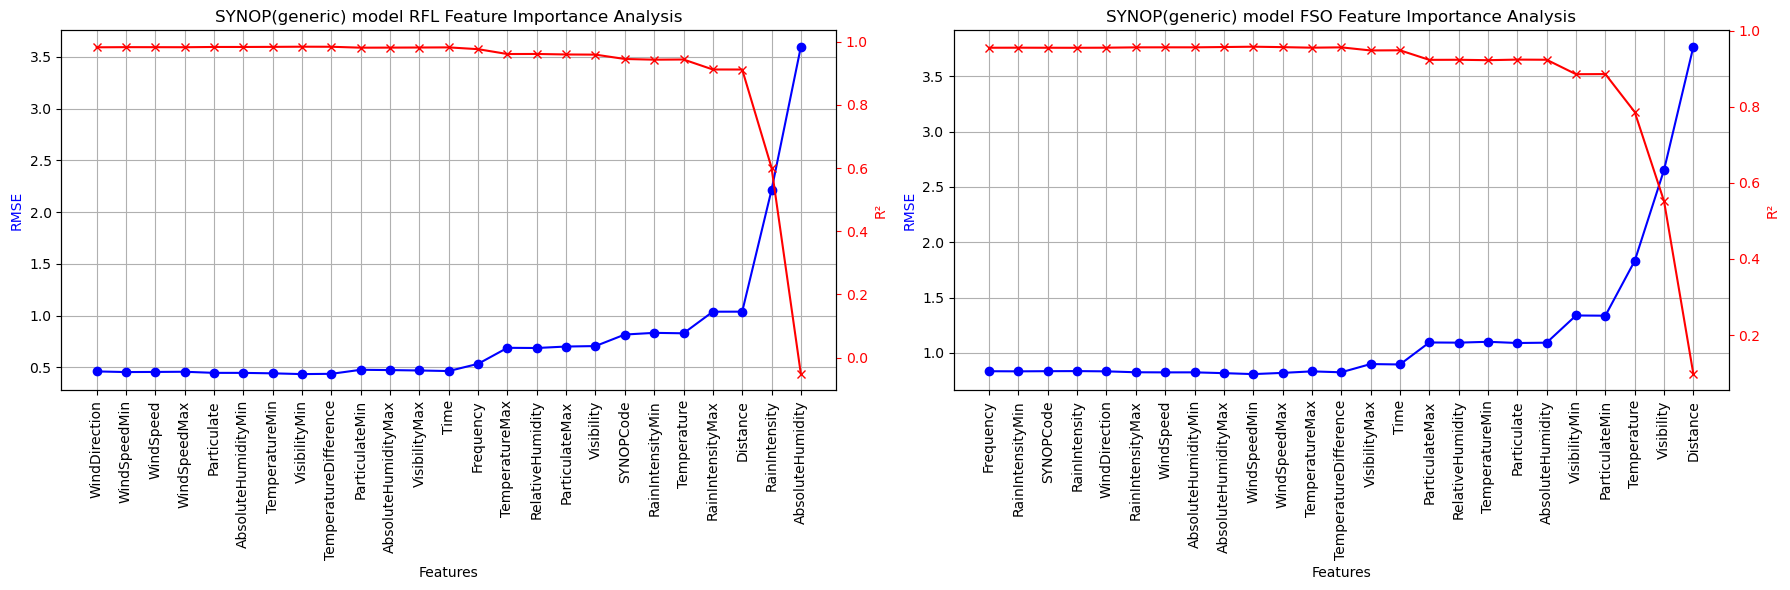

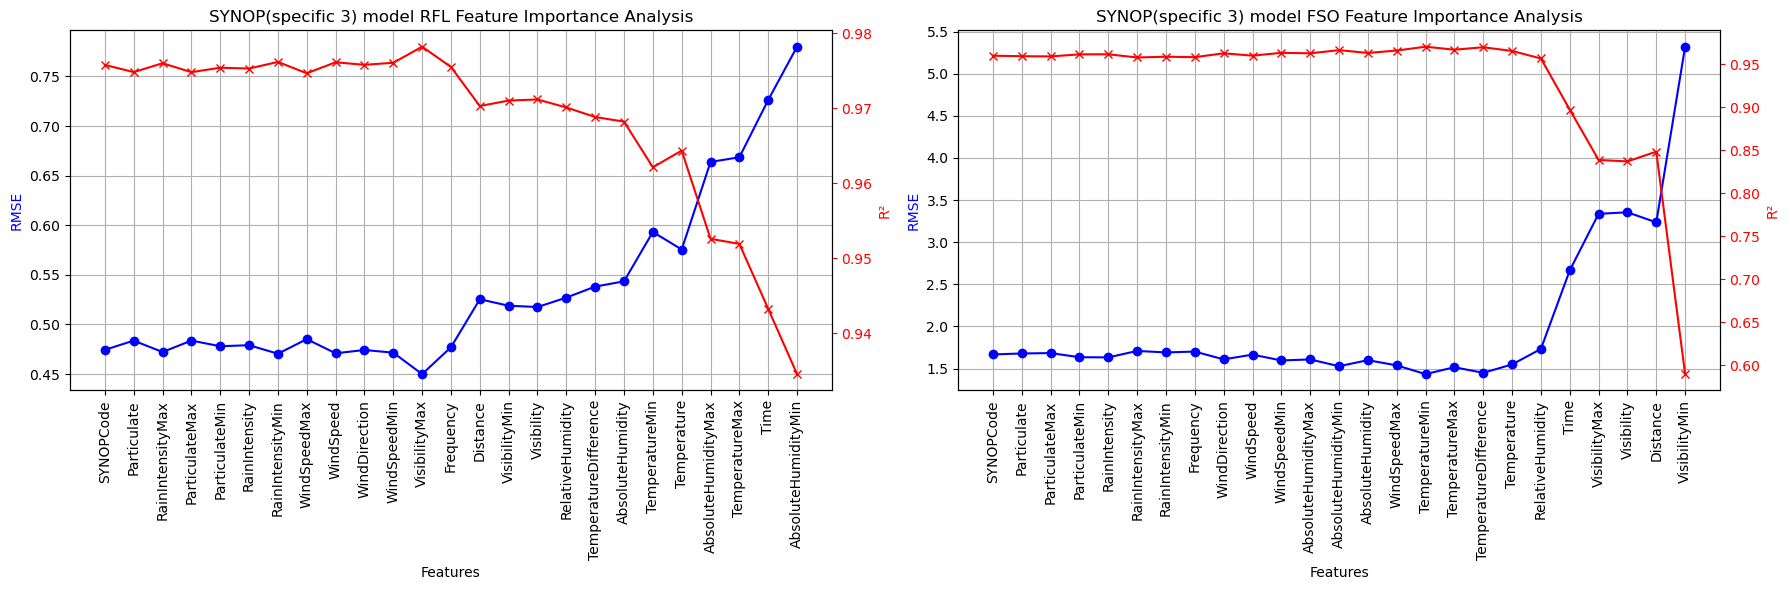

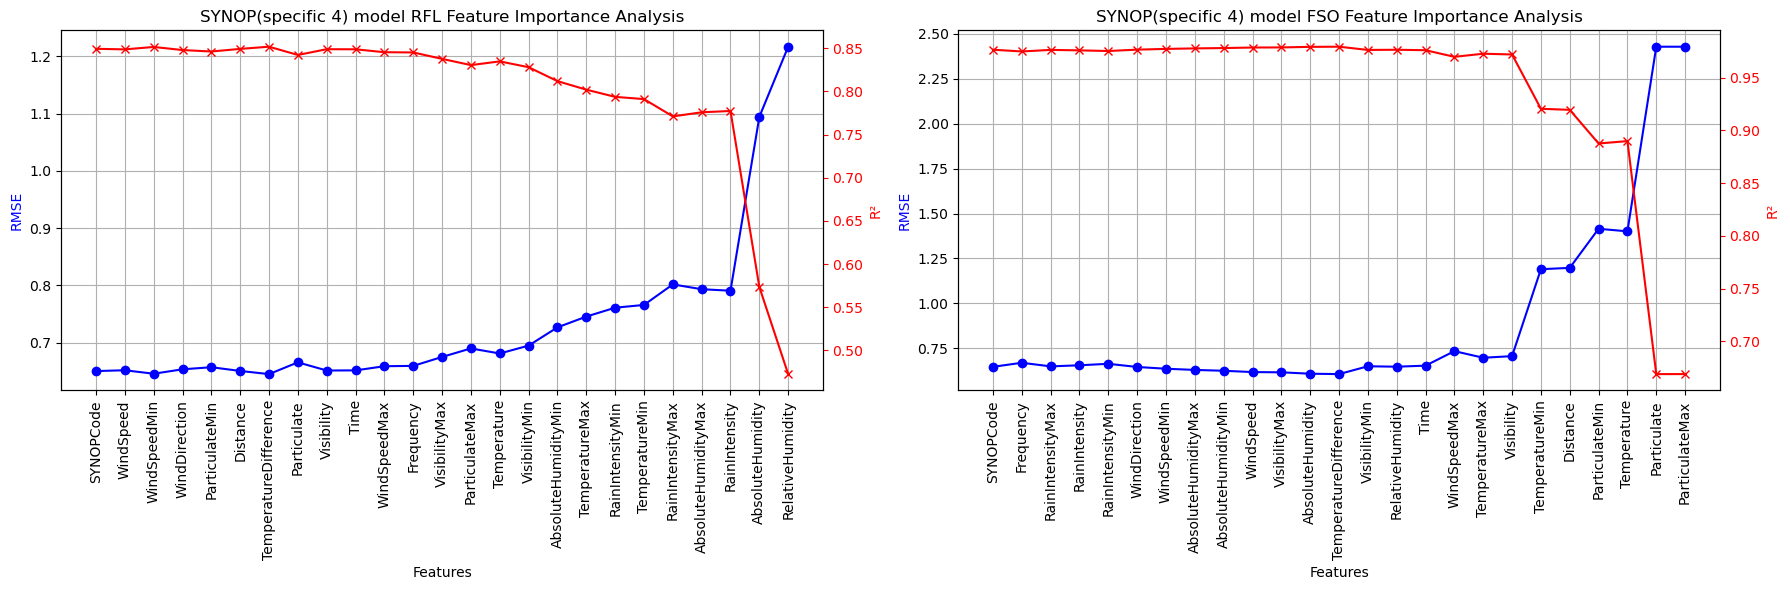

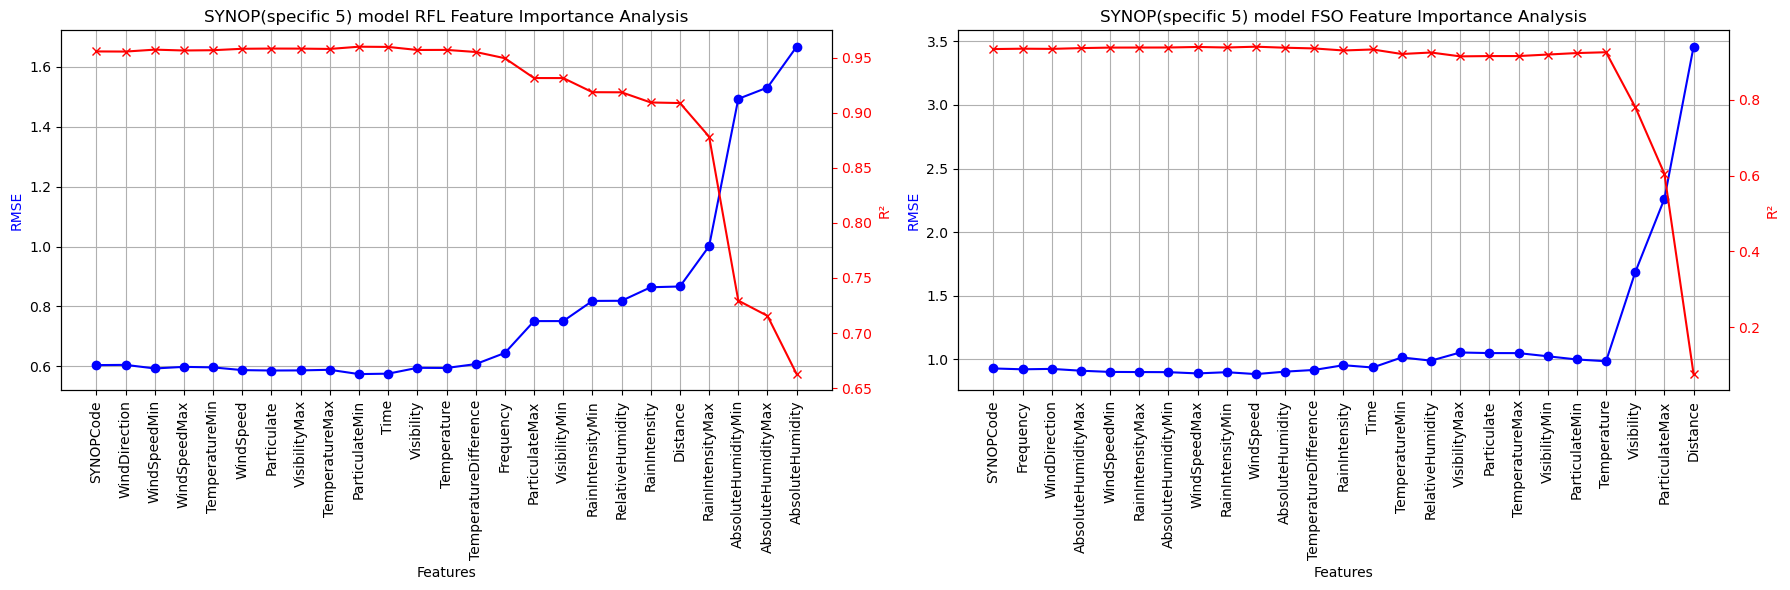

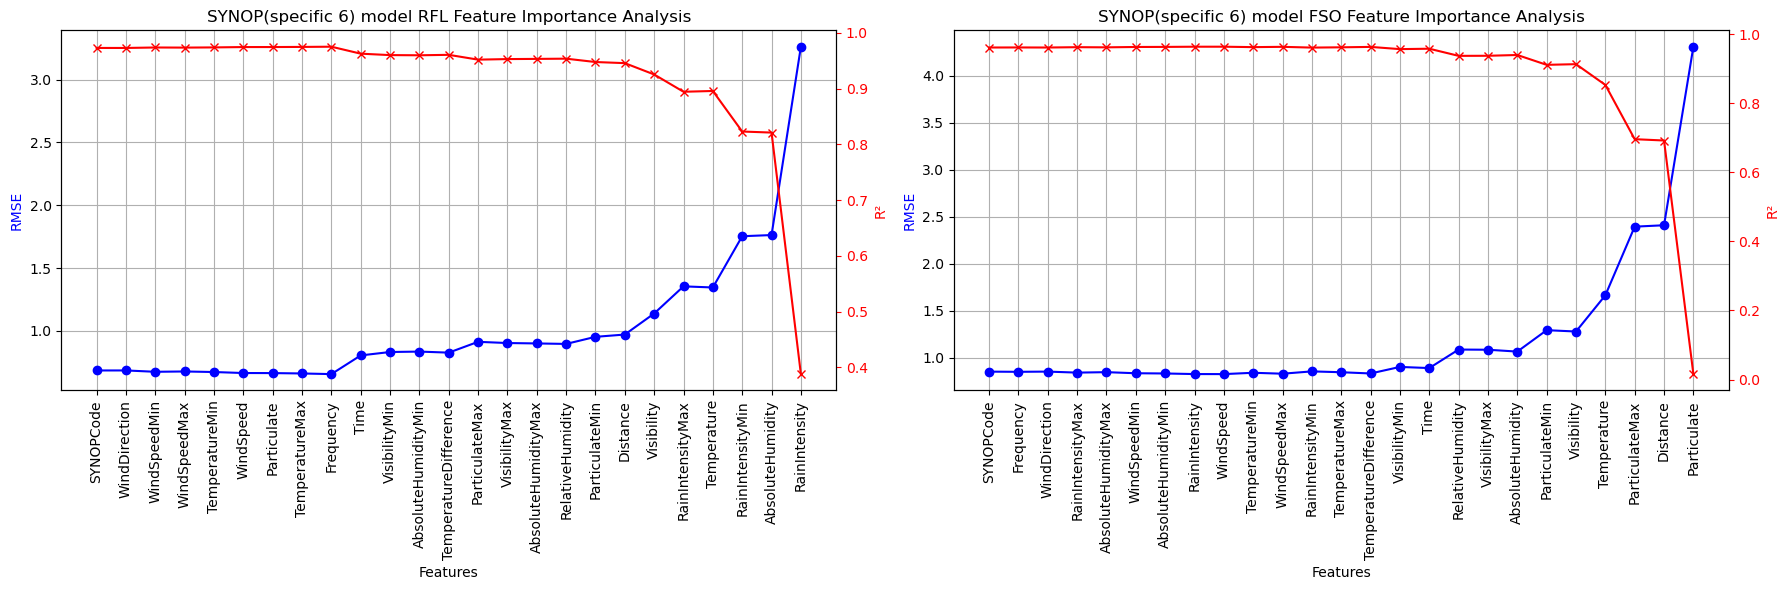

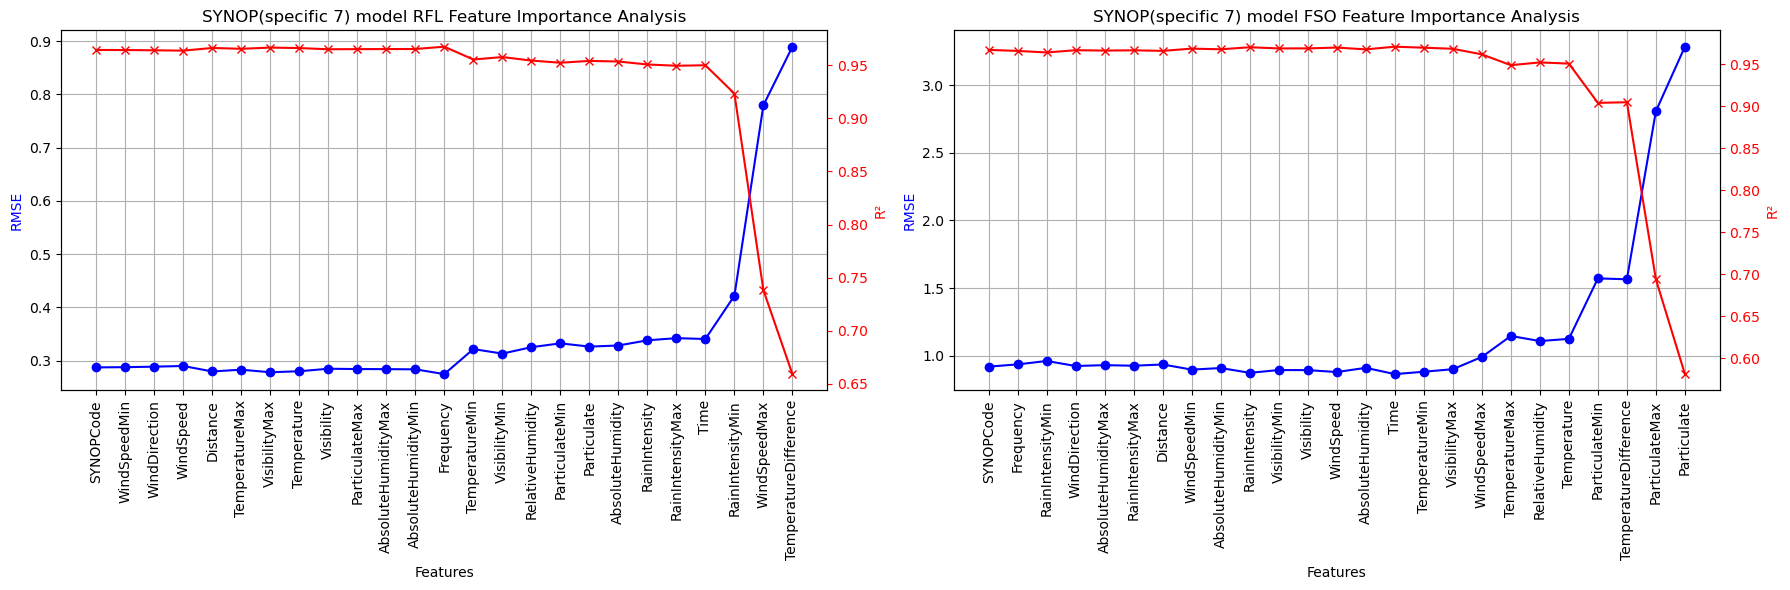

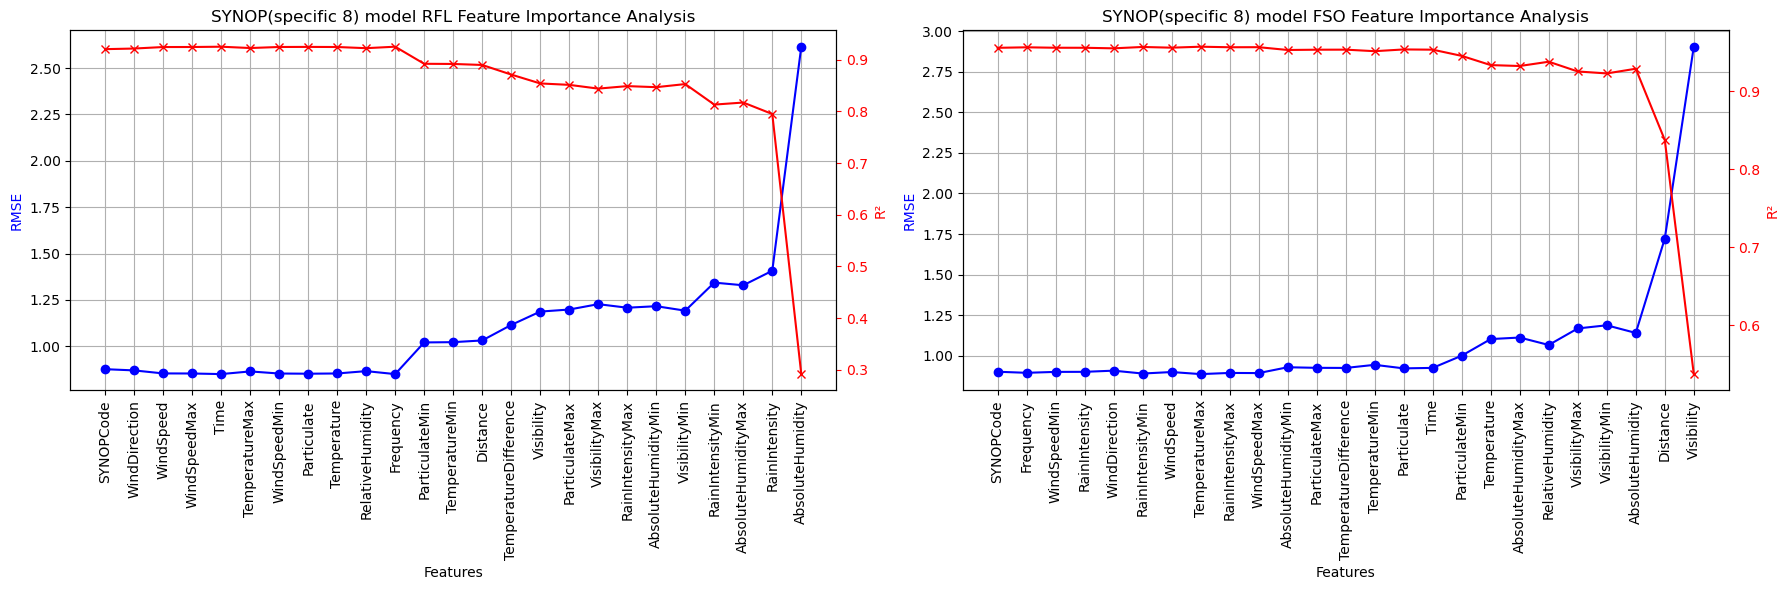

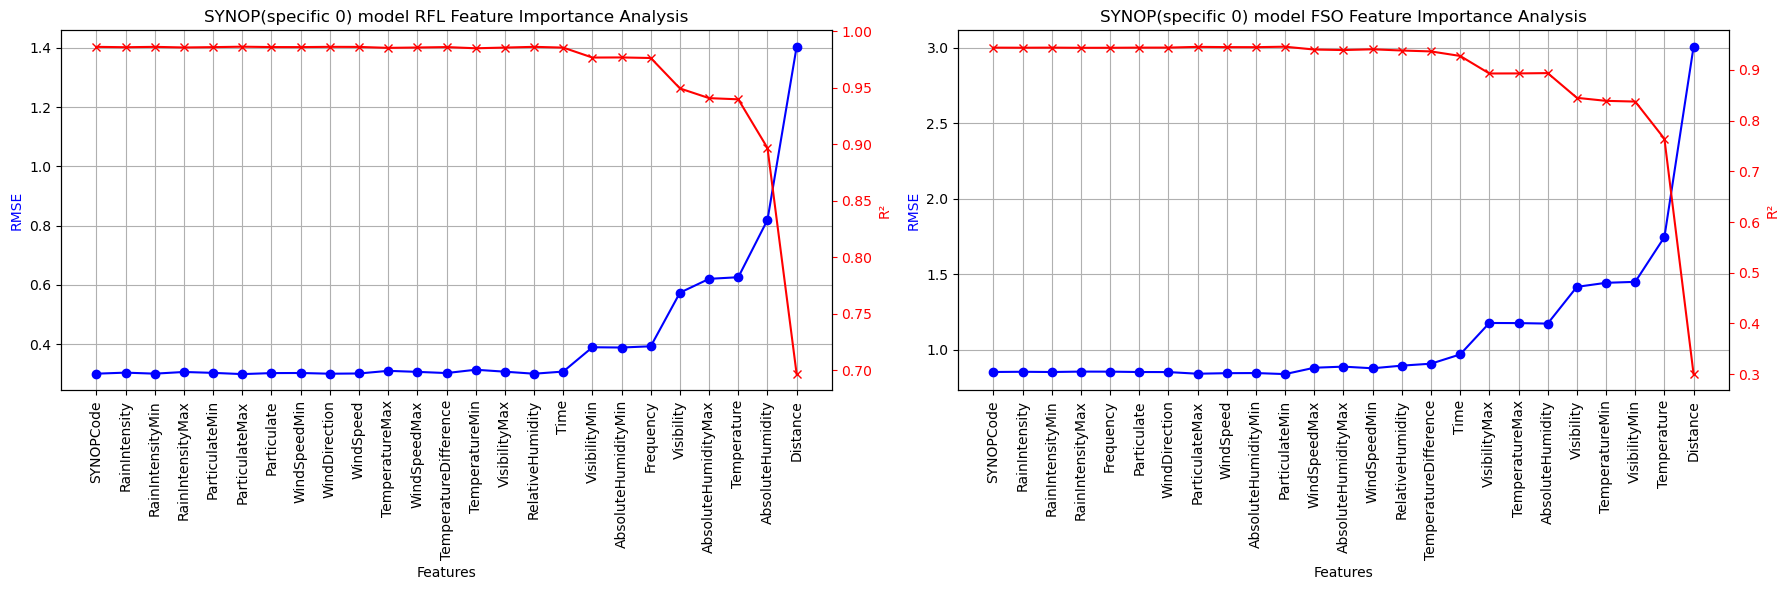

In [20]:
plot_results(g_result_RFL, g_result_FSO, 'generic')
plot_results(III_result_RFL, III_result_FSO, 'specific 3')
plot_results(IV_result_RFL, IV_result_FSO, 'specific 4')
plot_results(V_result_RFL, V_result_FSO, 'specific 5')
plot_results(VI_result_RFL, VI_result_FSO, 'specific 6')
plot_results(VII_result_RFL, VII_result_FSO, 'specific 7')
plot_results(VIII_result_RFL, VIII_result_FSO, 'specific 8')
plot_results(Zero_result_RFL, Zero_result_FSO, 'specific 0')